<a href="https://colab.research.google.com/github/k41n3w/EmpregaPop/blob/main/TCC_Predi%C3%A7%C3%A3o_de_Churn_de_Academia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ydata-profiling

In [2]:
import pandas as pd

# Carregar o CSV exportado
df_clientes = pd.read_csv('/content/clientes_apenas.csv')


In [3]:
from ydata_profiling import ProfileReport

# Criar o relatório exploratório
profile = ProfileReport(df_clientes, title="Relatório de Clientes", explorative=True)

# Exportar como HTML
profile.to_file("relatorio_clientes.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:01<00:00,  7.18it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
from google.colab import files

files.download("relatorio_clientes.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# =========================================
# 2. Imports e carregamento
# =========================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import joblib

# ► Ajuste o caminho se necessário (Colab → /content/…)
df = pd.read_csv('/content/clientes_apenas.csv')

# =========================================
# 3. FEATURE ENGINEERING
# =========================================
# A) Variável-alvo (churn / cancelado)
df['cancelado'] = (df['SN_ATIVO'].str.upper() == 'N').astype(int)

# B) Selecionar colunas
num_cols = ['IDADE']                      # numéricas
cat_cols = ['ID_TREINADOR', 'ID_UNIDADE', # categóricas
            'HORARIO', 'ID_TIPO_PLANO']

X = df[num_cols + cat_cols]
y = df['cancelado']

# =========================================
# 4. Treino / validação
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# =========================================
# 5. Pipeline + Random Forest
# =========================================
numeric_transformer   = Pipeline([('scaler', StandardScaler())])
categorical_transform = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    [('num', numeric_transformer, num_cols),
     ('cat', categorical_transform, cat_cols)]
)

rf = RandomForestClassifier(
    n_estimators=350,
    min_samples_leaf=3,
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([('prep', preprocessor),
               ('rf'  , rf)])

clf.fit(X_train, y_train)

# =========================================
# 6. Avaliação
# =========================================
proba = clf.predict_proba(X_test)[:, 1]
pred  = clf.predict(X_test)

print(f'ROC-AUC: {roc_auc_score(y_test, proba):.4f}\n')
print(classification_report(y_test, pred, digits=4))
print('Matriz de Confusão:\n', confusion_matrix(y_test, pred))

# =========================================
# 7. Salvar o modelo
# =========================================
joblib.dump(clf, 'random_forest_churn.pkl')
print('Modelo salvo em random_forest_churn.pkl')


ROC-AUC: 0.5113

              precision    recall  f1-score   support

           0     0.4934    0.4916    0.4925      1601
           1     0.5308    0.5327    0.5318      1729

    accuracy                         0.5129      3330
   macro avg     0.5121    0.5121    0.5121      3330
weighted avg     0.5128    0.5129    0.5129      3330

Matriz de Confusão:
 [[787 814]
 [808 921]]
Modelo salvo em random_forest_churn.pkl


AUC: 0.5113


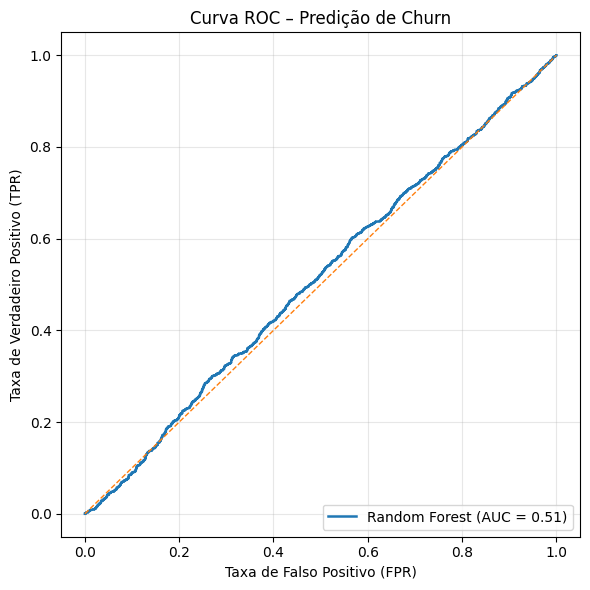

In [6]:
# ===========================================
# Avaliação: curva ROC e AUC
# ===========================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- 1. Probabilidades da classe positiva (cancelado) ---
y_proba = clf.predict_proba(X_test)[:, 1]   # ← use 'clf' e não 'model'

# --- 2. Pontos da curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")

# --- 3. Plot ---
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linewidth=1.8, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("Taxa de Falso Positivo (FPR)")
plt.ylabel("Taxa de Verdadeiro Positivo (TPR)")
plt.title("Curva ROC – Predição de Churn")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()

# --- 4. Salvar o gráfico ---
plt.savefig("roc_curve_churn.png", dpi=300)
plt.show()
